# Nonlinear bias in CCL

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
%matplotlib inline

## Preliminaries
Let's begin by setting up a cosmology and a couple of redshift distributions and bias functions

In [2]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Redshift-dependent functions
z = np.linspace(0,1.2,1024)
# Redshift distributions
nz1 = np.exp(-((z-0.5)/0.05)**2/2)
nz2 = np.exp(-((z-0.65)/0.05)**2/2)
# growth factor
 #gz = ccl.growth_factor(cosmo,1./(1+z))
# Galaxy Bias
b_1 = 2.0 # constant values for now
b_2 = 1.0
b_s = 1.0
# ell values for C_ell calculation below
ells = np.geomspace(2,2000,20)

## Tracer objects
Now we define some new "tracer objects" that use nonlinear biasing

In [3]:
# This tracer will only include the density contribution. Bias must be 1 with the current setup, which applies bias with P(k)
bz1=np.ones_like(z)
gc_d1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=(z,bz1), mag_bias=None)
gc_d2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=(z,bz1), mag_bias=None)
# This tracer will only include the lensing shear contribution (by setting the ia_bias to None)
wl_s = ccl.WeakLensingTracer(cosmo, dndz=(z,nz2), has_shear=True, ia_bias=None)

# tracers for the test with linear bias with halofit
bz_hf=b_1*np.ones_like(z)
gc_d1_hf = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=(z,bz_hf), mag_bias=None)
gc_d2_hf = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=(z,bz_hf), mag_bias=None)

In [4]:
# We also need "PTTracers" which define with PT is being done.
PTTracer1 = ccl.PTNumberCountsTracer(b1=b_1,b2=b_2,bs=b_s)
PTTracer2 = ccl.PTNumberCountsTracer(b1=b_1,b2=b_2,bs=b_s)
PTmatter = ccl.PTNumberCountsTracer(b1=1.0) # b1=1 is equivalent to DM.

## Initialize the PT workspace, and do calculations.

In [5]:
PTW=ccl.PTWorkspace()
pk_gg=ccl.get_pt_pk2d(cosmo, PTW, tracer1=PTTracer1, tracer2=PTTracer2,sub_lowk=True)
pk_gm=ccl.get_pt_pk2d(cosmo, PTW, tracer1=PTTracer1, tracer2=PTmatter)

In [6]:
#use those power spectra to calculate C_ells.
cl_gc_nonlin = ccl.angular_cl(cosmo, gc_d1, gc_d2, ells, p_of_k_a=pk_gg)
cl_ggl_nonlin = ccl.angular_cl(cosmo, gc_d1, wl_s, ells, p_of_k_a=pk_gm)

# or do it all in one step, which is probably what we want to do to use the tracer info properly.
# we might want to link the two different types of tracers, 
# or make a wrapper that creates both needed tracers at the same time.
cl_gc_nonlin = ccl.angular_cl(cosmo, gc_d1, gc_d2, ells, p_of_k_a=ccl.get_pt_pk2d(cosmo, PTW, tracer1=PTTracer1, tracer2=PTTracer2,
                                                                                  sub_lowk=True, use_nonlin=True))
cl_ggl_nonlin = ccl.angular_cl(cosmo, gc_d1, wl_s, ells, p_of_k_a=ccl.get_pt_pk2d(cosmo, PTW, tracer1=PTTracer1, tracer2=PTmatter,
                                                                                  sub_lowk=True, use_nonlin=True))
# Also make clustering cl without lowk subtracted for correlation function.
cl_gc_nonlin_lowk = ccl.angular_cl(cosmo, gc_d1, gc_d2, ells, p_of_k_a=ccl.get_pt_pk2d(cosmo, PTW, tracer1=PTTracer1, tracer2=PTTracer2,
                                                                                  sub_lowk=False, use_nonlin=True))

In [7]:
# Now let's calculate a few quantities with the standard (nonlinear) power spectrum for comparison.

cl_gc_halofit = ccl.angular_cl(cosmo, gc_d1_hf, gc_d2_hf, ells)
cl_ggl_halofit = ccl.angular_cl(cosmo, gc_d1_hf, wl_s, ells)

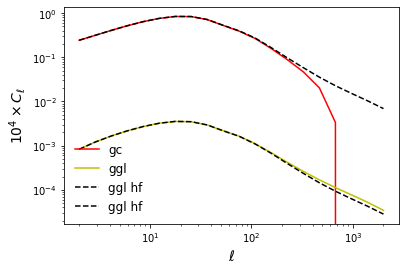

In [8]:
# Plot stuff
plt.plot(ells, 1E4*cl_gc_nonlin, 'r-', label='gc')
plt.plot(ells, 1E4*cl_ggl_nonlin, 'y-', label='ggl')
plt.plot(ells, 1E4*cl_gc_halofit, 'k--', label='ggl hf')
plt.plot(ells, 1E4*cl_ggl_halofit, 'k--', label='ggl hf')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize=14)
plt.ylabel('$10^4\\times C_\\ell$', fontsize=14)
plt.legend(loc='lower left', fontsize=12, frameon=False)
plt.show()

In [9]:
# Finally, let's do some correlation functions
theta_deg = np.logspace(-1, np.log10(5.), 20) # Theta is in degrees

#Clustering:
#xi_clu = ccl.correlation(cosmo, ells, cl_gc_nonlin2, theta_deg, corr_type='GG', method='FFTLog')
# Note, after updating numpy, the above integral appears to crash.
# It is clearly numerically unstable, but it was not crashing before.

#Instead, use the one with low k contribution left in:
xi_clu = ccl.correlation(cosmo, ells, cl_gc_nonlin_lowk, theta_deg, corr_type='GG', method='FFTLog')

#galaxy-galaxy lensing
xi_ggl = ccl.correlation(cosmo, ells, cl_ggl_nonlin, theta_deg, corr_type='GL', method='FFTLog')

#halofit versions
xi_clu_halofit = ccl.correlation(cosmo, ells, cl_gc_halofit, theta_deg, corr_type='GG', method='FFTLog')
xi_ggl_halofit = ccl.correlation(cosmo, ells, cl_ggl_halofit, theta_deg, corr_type='GL', method='FFTLog')


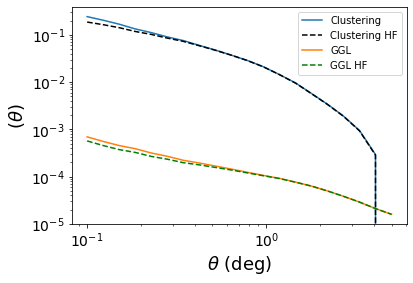

In [10]:
#And plot the results
plt.plot(theta_deg, xi_clu, label='Clustering')
plt.plot(theta_deg, xi_clu_halofit, 'k--', label='Clustering HF')
plt.plot(theta_deg, xi_ggl, label='GGL')
plt.plot(theta_deg, xi_ggl_halofit, 'g--',label='GGL HF')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)',fontsize=18)
plt.ylabel(r'$(\theta)$',fontsize=18)
plt.show()